In [42]:
import numpy as np
import requests
import urllib.parse
import os, sys, json

#set your api_token here:
BASE = 'http://treasuremap.space/api/v0'
api_token = "zd6DGajyV66nlxuGhWt4CzIbdJ3wwr2UzlbkEg"

In [43]:
def get_time_and_band(instrument='MMT'):
    BASE = 'http://treasuremap.space/api/v0'
    api_token = "zd6DGajyV66nlxuGhWt4CzIbdJ3wwr2UzlbkEg"
    
    TARGET = 'pointings'

    #define the filtering parameters 
    #grab all of the completed pointings taken with a specific instrument for a given event

    graceid = 'S190425z'

    params = {
        "api_token":api_token,
        "instrument":instrument,
        "graceid":graceid,
        "status":"completed"
    }

    url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
    r = requests.get(url = url)
    print("There are %s pointings" % len(json.loads(r.text)))

    #print the first
    # print(json.loads(r.text))

    pointings = []
    positions = []
    depths = []
    depth_units = []
    depth_errs = []
    time = []
    pos_angle = []
    band = []
    for p in range(len(json.loads(r.text))):
        pointing = json.loads(json.loads(r.text)[p])
        pointings.append(json.loads(json.loads(r.text)[p]))
        positions.append(pointing["position"])
        depths.append(pointing["depth"])
        depth_units.append(pointing["depth_unit"])
        depth_errs.append(pointing["depth_err"])
        time.append(pointing["time"])
        pos_angle.append(pointing["pos_angle"])
        band.append(pointing["band"])
    
    return time, band

In [44]:
# print(depth_units)

In [45]:
from datetime import datetime

datetime_object = datetime.strptime('2019-04-25T11:57:26', '%Y-%m-%dT%H:%M:%S')
print(datetime_object)

2019-04-25 11:57:26


In [46]:
BASE = 'http://treasuremap.space/api/v0/'
TARGET = 'pointings'

payload = {'graceid':'S190425z', 'api_token':api_token}
r = requests.get(url = BASE+TARGET, params = payload)
results = r.json()

pointings = []
for tile in results:
    tile = eval(tile)
    position = tile["position"]
    ra = float(position.split()[1].split('(')[1])
    dec = float(position.split()[2].split(')')[0])
    pos_angle = tile['pos_angle']
    instrument_id = tile['instrumentid']
    pointings.append([instrument_id, ra,dec,pos_angle])

**Fetch Footprints Table**

In [47]:
TARGET='footprints'
r = requests.get(url = BASE+TARGET, params = payload)

In [48]:
results = r.json()

footprints_dict={}
for footprint_obj in results:
    footprint_obj = eval(footprint_obj)
    inst_id = int(footprint_obj['instrumentid'])
    footprint = footprint_obj['footprint']
    sanitized = footprint.strip('POLYGON ').strip(')(').split(',')
    footprint = []
    for vertex in sanitized:
        obj = vertex.split()
        ra = float(obj[0])
        dec = float(obj[1])
        footprint.append([ra,dec])
    new_entry = {inst_id:footprint}
    footprints_dict.update(new_entry)

**Fetch Instruments Table**

In [49]:
TARGET='instruments'
r = requests.get(url = BASE+TARGET, params = payload)

In [50]:
results = r.json()

instrument_dict={}
for instrument in results:
    instrument=eval(instrument)
    inst_id = instrument['id']
    inst_name = instrument['instrument_name']
    new_entry = {inst_id: inst_name}
    instrument_dict.update(new_entry)

**Define Rotation and Projection Functions**

In [51]:
def rotate(footprint, angle):
        #footprint is a list of vertices points
        #   vertice points = [ra, dec]

        # angle is the pos_angle of the pointing

        rot_footprint = []
        for p in footprint:
                x, y = p[0], p[1]
                r = math.sqrt(x*x + y*y)
                if x < 0:
                        r = (-1.0)*r
                theta = math.atan(y/x)-angle
                new_x = r*math.cos(theta)
                new_y = r*math.sin(theta)
                rot_footprint.append([new_x, new_y])

        return rot_footprint

In [52]:
def project(footprint, _ra, _dec):
        #footprint is a list of vertices points
        #   vertice points = [ra, dec]

        #_ra and _dec are the translated coordinates

        proj_footprint = []
        for p in footprint:
            if p[0]+_ra > 360:
                  ra = 360 - p[0]+_ra
            elif p[0]+_ra < 0:
                  ra = 360 + p[0]+_ra
            else:
                  ra = p[0] + _ra

            if p[1]+_dec > 90:
                dec = 90 - p[1]+_dec
            elif p[1]+_dec < -90:
                dec = -90 + p[1] + _dec
#             elif p[1]+_dec < 0:
#                   dec = 90 -  p[1]+_dec
            else:
                  dec = p[1] + _dec

            proj_footprint.append([ra, dec])
        return proj_footprint

In [53]:
import healpy as hp

In [54]:
footprints_dict.get(22)

[[-0.0225, 0.0225],
 [0.0225, 0.0225],
 [0.0225, -0.0225],
 [-0.0225, -0.0225],
 [-0.0225, 0.0225]]

In [55]:
#Using this function to convert the string Polygons to a list of points
def sanatize_footprint_ccds(ccds):
    footprint_ccds = []
    for footprint in ccds:
        sanitized = footprint.strip('POLYGON ').strip(')(').split(',')
        polygon = []
        for vertex in sanitized:
            obj = vertex.split()
            ra = float(obj[0])
            dec = float(obj[1])
            polygon.append([ra,dec])
        footprint_ccds.append(polygon)
    return footprint_ccds

Requested Footprint Info


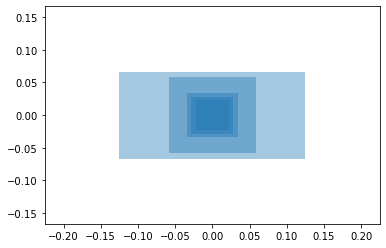

In [56]:
# Getting Instrument Footprint
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

TARGET = 'footprints'

params = {
            "api_token":api_token,
            "name":"MMT"
        }

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
r = requests.get(url = url)

print("Requested Footprint Info")

footprints = json.loads(r.text)
polygons = []
patches = []

#This gets all of the Polygon information from the json list
for f in footprints:
    f_info = json.loads(f)
    polygons.append(f_info['footprint'])

#converts the polygons to a list of list of points (list of polygons)
sanatized_ccds = sanatize_footprint_ccds(polygons)

#gather the points for ylim and xlim
xs, ys = [], []

for sc in sanatized_ccds:
    #add the polygon list of points to the matplotlib patch collection
    patches.append(Polygon(sc, True))
    for p in sc:
        xs.append(p[0])
        ys.append(p[1])
    
p = PatchCollection(patches, alpha=0.4)

fig, ax = plt.subplots()
ax.set_xlim(min(xs)-.1, max(xs)+.1)
ax.set_ylim(min(ys)-.1, max(ys)+.1)
ax.add_collection(p)
plt.show()

In [57]:
import healpy as hp

In [187]:
hpx, header = hp.read_map('LALInference.fits.gz,0', h=True, verbose=False)
# hp.npix2nside(len(hpx))

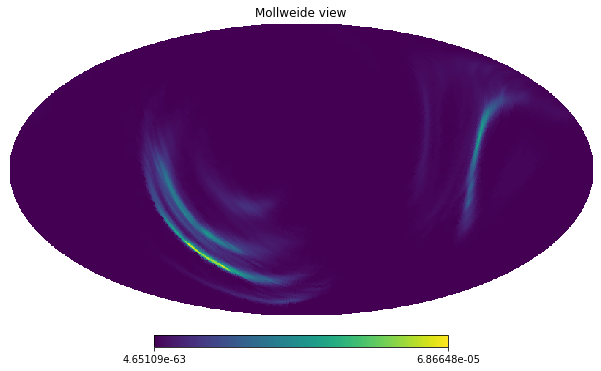

In [59]:
hp.mollview(hpx)

In [60]:
# print(footprints_dict.get(22)[:-1])
xyz = [[-0.69601758, -0.41315628, -0.58724902],

       [-0.68590811, -0.40679797, -0.60336181],

       [-0.69106913, -0.39820114, -0.60320752],

       [-0.7011786 , -0.40455945, -0.58709473]]

ipix_poly = hp.query_polygon(256, xyz)
print(ipix_poly)

[624725 624726 625750 625751 626773 626774 627798 627799 628821 628822
 629846 629847]


In [61]:
hpx[ipix_poly].sum()

2.9306794937050176e-15

In [62]:
MMT_pointings = []
CSS_pointings = []
GOTO_pointings = []
for p in range(len(pointings)):
    if pointings[p][0] == 22:
        MMT_pointings.append(pointings[p])
    if pointings[p][0] == 71:
        GOTO_pointings.append(pointings[p])
    if pointings[p][0] == 11:
        CSS_pointings.append(pointings[p])
MMT_pointings = np.array(MMT_pointings)[:,1:3]
CSS_pointings = np.array(CSS_pointings)[:,1:3]
GOTO_pointings = np.array(GOTO_pointings)[:,1:3]

In [63]:
from datetime import datetime
def get_important_things(instrument):
    # for a given instrument, returns the median time of the pointing
    # since the event as well as the band
    time, band = get_time_and_band(instrument)
    event = '2019-04-25T08:18:05'
    FMT = '%Y-%m-%dT%H:%M:%S'
    time = [datetime.strptime(t[:19], FMT) - datetime.strptime(event, FMT) for t in time]
    time = [t.days + t.seconds/86400 for t in time]
    return time, band

In [64]:
mmt_time, mmt_band = get_important_things('MMT')
goto_time, goto_band = get_important_things('GOTO-4')
css_time, css_band = get_important_things('CSS')

There are 67 pointings
There are 303 pointings
There are 73 pointings


In [134]:
mmt = {}
mmt['pointings'] = MMT_pointings
mmt['time'] = np.array(mmt_time)
mmt['band'] = np.array(mmt_band)
css = {}
css['pointings'] = CSS_pointings
css['time'] = np.array(css_time)
css['band'] = np.array(css_band)
goto = {}
goto['pointings'] = GOTO_pointings
goto['time'] = np.array(goto_time)
goto['band'] = np.array(goto_band)

In [135]:
# test out a time window
t_range = [0.25, 1.25]
goto_time = goto['time']
indices = []
for i in range(len(goto_time)):
    if t_range[0] <= goto_time[i] <= t_range[1]:
        indices.append(i)
# goto['pointings'][indices]

In [136]:
print(footprints_dict.get(71)[:-1])
print(css['pointings'][0])

[[-1.85, 2.45], [1.85, 2.45], [1.85, -2.45], [-1.85, -2.45]]
[-112.788    16.5661]


In [137]:
ra, dec = np.deg2rad(-112.788), np.deg2rad(16.5661)

In [138]:
colat, colong = np.pi/2 - dec, 2*np.pi - ra

In [139]:
colat, colong

(1.281663337580264, 8.25170726391895)

In [140]:
hp.ang2vec(colat, colong)

array([-0.3712453 ,  0.88367571,  0.28512131])

In [141]:
def deg2rad(point):
    return np.deg2rad(point[0]), np.deg2rad(point[1])

def astro2sky(point):
    colat = np.pi/2 - point[1]
    if ra < 0:
        colong = 2*np.pi + point[0]
    else:
        colong = point[0]
    return [colat, colong]

def sky2vec(point):
    return hp.ang2vec(point[0], point[1])

In [142]:
def point_projector(point):
    point = deg2rad(point)
    point = astro2sky(point)
    point = sky2vec(point)
    return point

In [143]:
point_projector([-112.788, 16.5661])

array([-0.3712453 , -0.88367571,  0.28512131])

In [144]:
def query_footprint(footprint, pointing):
    polygon = []
    for p in footprint:
        point = np.array(p) + np.array(pointing)
        point = point_projector(point)
        polygon.append(point)
    return hp.query_polygon(256, polygon)

In [171]:
def coverage_in_time(ti, tf, instrument='css'):
    """
    Returns total probability coverage during time period
    ti: initial time in days
    tf: final time in days
    instrument: either goto or css, the instrument dictionary
    """
#     assert (instrument is css) or (instrument is goto)
    if instrument == 'css':
        footprint = footprints_dict.get(11)[:-1]
        instrument = css
    elif instrument == 'goto':
        footprint = footprints_dict.get(71)[:-1]
        instrument = goto
    pointings = instrument['pointings']
    times = instrument['time']
    indices = []
    for i in range(len(times)):
        if ti <= times[i] <= tf:
            indices.append(i)
    pointings = pointings[indices]
    idx = []
    for pointing in pointings:
        idx = idx + list(query_footprint(footprint, pointing))
    idx = list(dict.fromkeys(idx)) # kills duplicates
    p = hpx[idx].sum()
    return p, idx

In [174]:
p, idx = coverage_in_time(0.75, 1.5, instrument='goto')
p

0.057590819847420545

In [208]:
def coverage_iterator(time, instrument):
    """
    Given a list describing the number of time windows,
    the beginning of the first window and the end of the last,
    iterates through an instrument's sky coverage to determine whether
    a detection was made, and if so, in which epoch.
    - time: time list [dt, ti, tf]
    - instrument: instrument string
    """
    ti = time[1]
    tf = time[2]
    nt = time[0]
    dt = (tf - ti) / nt
    t2 = ti + dt
    hpx2 = np.copy(hpx)
    for i in range(nt):
        ti += dt * i
        t2 += dt * i
        p, idx = coverage_in_time(ti, t2, instrument)
        r = np.random.uniform()
        if r <= p:
            return [ti, t2], i
        else:
            hpx2[idx] = 0
            hpx2 /= hpx2.sum()
    return None

In [209]:
coverage_iterator([30, 0.25, 15.25], 'goto')

([0.25, 0.75], 0)

In [215]:
tot = 0
hits = 0
maxm = 1000
ilist = []
while tot < maxm:
    result = coverage_iterator([30, 0.25, 15.25], 'goto')
    if result is None:
        pass
    else:
        hits += 1
        ilist.append(result[1])
    tot += 1

print("Mean Epoch of Detection", np.array(ilist).mean())    
print("Detection Rate", hits / tot)

Mean Epoch of Detection 0.47368421052631576
Detection Rate 0.152


In [213]:
hits / tot

0.172